# Installation

# Deep learning architectures

We will construct a number of different network architectures and compare their performance. For all of the following we perform a coarse hyperparameter selection (by hand) using the test set: you should **report the hyperparameters you found**, and **plot the training and test classification accuracy as a function of iteration.**

In [1]:
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable # not found in torch 0.4
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#transform = transforms.Compose([transforms.ToTensor(), 
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def plot_acc(train_acc, test_acc, losses):
    fig = plt.figure()
    fig.set_size_inches([12, 6])
    
    plt.plot(train_acc, 'y', alpha = 0.5, label = 'Training Accuracy')
    plt.plot(test_acc, 'r', alpha = 0.5, label = 'Testing Accuracy')
    plt.plot(losses/np.max(losses), 'g', alpha = 0.5, label = 'Loss')
    plt.ylabel('Accuracy'); plt.xlabel('Interations')
    plt.ylim(0, plt.ylim()[1]); plt.ylim(0, 1)
    
    plt.legend()
    plt.show()

Let's look at some images

              dog             truck             horse             plane


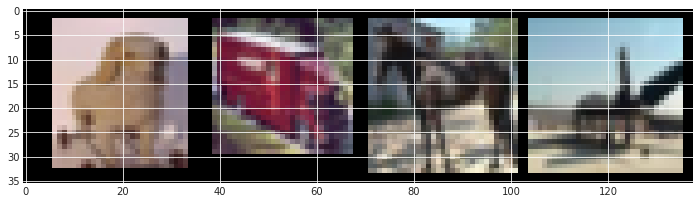

In [4]:
def imshow(img):
    npimg = img.numpy()
    norm_img = (npimg - np.min(npimg))/(np.max(npimg) - np.min(npimg)) # min-max normalization
    fig = plt.figure()
    fig.set_size_inches([12, 6])
    plt.imshow(np.transpose(norm_img, (1, 2, 0)))

# get some random training images
data_iterator = iter(trainloader)
images, labels = data_iterator.next()

imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join('%17s' % classes[labels[j]] for j in range(4))) # print labels
plt.show()

In [5]:
images[0,0,:,:].shape

torch.Size([32, 32])

In [6]:
# increase batch_size
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Part (a) - Logistic Regression

**Fully connected output, $0$ hidden layers (logistic regression):** 

We begin with the simplest network possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is, conceptually it could be written as

$$ x^{out} = W\cdot \text{vec}(x^{in}) + b $$

where $x^{out} \in \mathbb{R}^{10}$, $x^{in} \in \mathbb{R}^{32 \times 32 \times 3}$, $W \in \mathbb{R}^{10, 3072}$, $b \in \mathbb{R}^{10}$ where $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mathbb{R}^{a \times b \times c}$, we let vec$(x) \in \mathbb{R}^{abc}$ be the reshaped from a tensor into a vector (in an arbitrary but consistent pattern).

#### Model for part (a)

Define model architecture

In [7]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()    
        self.linear = nn.Linear(32*32*3, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        out = self.linear(x)
        return out

Compile model

In [8]:
#lr_net = LinearRegression().cuda()
lr_net = LinearRegression()

Choose Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr_net.parameters(), lr=0.001, momentum=0.9)

Designate your performance metric (accuracy in our case)

In [10]:
def evaluate(dataloader, model, linear=False):
    correct, total = 0, 0
    
    for data in dataloader:
        images, labels = data
        #if(linear):
        #    images = images.view(-1, 32*32*3) # using linear layer, not convolutional
        #outputs = model(Variable(images.cuda()))
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #correct += (predicted == labels.cuda()).sum()
        correct += (predicted == labels).sum()

    return correct/total

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Train + Evaluate concurrently

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lr_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: addmm(): argument 'mat1' (position 1) must be Variable, not torch.FloatTensor

In [ ]:
train_accuracy_a, test_accuracy_a = [], []
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs       
        inputs, labels = data
        #inputs = inputs.view(-1, 32*32*3)
        # wrap them in Variable
        #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        inputs, labels = Variable(inputs, Variable(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize (this is all there is)
        outputs = lr_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        
        minibatchs = 4000
        if i % minibatchs == minibatchs - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / minibatchs))
            running_loss = 0.0
            
            # performance on training data
            train_acc = evaluate(trainloader, lr_net)           
            train_accuracy_a.append(train_acc)
            print('Accuracy of the network on the 50000 training images: %d %%' % (100 * train_acc))
            
            # performance on validation/test set
            test_acc = evaluate(testloader, lr_net)
            test_accuracy_a.append(test_acc)
            print('Accuracy of the network on the 10000 test images: %d %%' % (100 * test_acc))

print('Finished Training')

**The training stage can be abstracted.** Notice that we have only hardcoded the dataset and the print statements.

In [ ]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=1, linear=False, weight_decay=False):
    train_accuracy, test_accuracy, loss_list = [], [], []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs       
            inputs, labels = data
            #if linear:
            #    inputs = inputs.view(-1, 32*32*3)
                
            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize (this is all there is)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

        train_acc = evaluate(trainloader, model, linear) 
        train_accuracy.append(train_acc)

        test_acc = evaluate(testloader, model, linear)
        test_accuracy.append(test_acc)
        loss_list.append(loss.data[0])
        
        # Decay learning rate
        if weight_decay and (epoch+1) % 20 == 0:
            curr_lr /= 3
            update_lr(optimizer, curr_lr)
        
        if epoch % 10 == 0:
            print('[Epoch %2d ||  Train acc: %d %% | Test acc: %d %% | loss: %.3f ]' 
                              % (epoch, train_acc*100, test_acc*100, running_loss/(len(trainloader))))

    print('Finished Training')
    return model, train_accuracy, test_accuracy, loss_list

In [ ]:
# adjust batch_size
batch_size=64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
lr_net = LinearRegression().cuda()

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr_net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
lr_net, train_acc, test_acc, losses = train(lr_net, trainloader, testloader,
                                           criterion, optimizer, epochs=5, linear=True)

In [ ]:
plot_acc(train_acc, test_acc, losses)

### Part (b)

Fully connected output, 1 fully connected hidden layer: we will have one hidden layber denoted as $x^{hidden} \in \mathbb{R}^M$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). the nonlinearity appled to the hidden layer will be the relu (relu$(x) = \max\{0, x\}$, elementwise). Conceptionally, one cold write this network as:

$$ x^{out} = W_2\text{relu}(W_1\text{vec}(x^{in}) + b_1) + b_2$$

where $W_1 \in \mathbb{R}^{M \times 3072}, b_1 \in \mathbb{R}^M, W_2 \in \mathbb{R}^{10 \times M}, b_2 \in \mathbb{R}^10$.

In [ ]:
M = 10

In [ ]:
class OneHidden(nn.Module):
    def __init__(self):
        super(OneHidden, self).__init__()
        self.fc1 = nn.Linear(32*32*3, M)
        self.fc2 = nn.Linear(M, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model_one_hidden = OneHidden().cuda()

In [ ]:
# data
batch_size=32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_one_hidden.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
model, train_acc, test_acc, losses = train(model_one_hidden, trainloader, testloader,
                                           criterion, optimizer, epochs=25, linear=True)

In [ ]:
plot_acc(train_acc, test_acc, losses)

### Part (c)


Fully connected output, 1 convolutional layer with max-pool: for a convolutional layer $W_1$ with individual filters of size $p \times p \times 3$ and output size $M$ (resonable choices are $M = 100, p = 5$) we have that Conv2d$(x^{input}, W_1) \in \mathbb{R}^{(33 - p)\times (33 - p) \times M}$. Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as Conv2d$(x^{input}, W) + b_1$ where $b_1$ is parameterized in $\mathbb{R}^M$. We will then apply a relu (relu doesn't change the tensor space) and pool. If we use a max-pool of size $N$ (a resonable choise is $N = 14$ to pool to $2 \times 2$ with $p = 5$) we have that 

$$ \text{MaxPool(relu(Conv2d}(x^{input}, W_1) + b_1)) \in \mathbb{R}^{\lfloor \frac{33-p}{N} \rfloor \times \lfloor \frac{33- p}{N} \rfloor \times M}.$$

We will then apply a fully connected layer to the output to get the final network given as

$$ x^{out} = W_2\text{vec}(\text{MaxPool}(\text{relu}(\text{Conv2d}(x^{in}, W_1) + b_1))) + b_2$$

where $W_2 \in \mathbb{R}^{10 \times M(\lfloor \frac{33-p}{N} \rfloor)^2}, b_2 \in \mathbb{R}^{10}$. The parameters $M, p, N$ (in addition to the stap size and the momentum are all hyperparameters.

In [ ]:
p = 5 ## size of the kernel / filter (that we are sliding along)
M = 100 ## 
N = 14
input_size = 32
output_size = 10
channel_nb = 3

# M = 6; N = 2

In [ ]:
np.floor_divide(input_size + 1 - p, N)

In [ ]:
floor_divide = 2

In [ ]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv1 = nn.Conv2d(channel_nb, M, p) ## 6x28x28 28 = 33-5
        self.pool = nn.MaxPool2d(N, N) ## 6 x 14 x 14
        self.fc1 = nn.Linear(M * floor_divide * floor_divide, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, M * floor_divide * floor_divide)
        x = self.fc1(x)
        return x

In [ ]:
model_one_conv = OneConv().cuda()

In [ ]:
# data
batch_size=64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_one_conv.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
model, train_acc, test_acc, losses = train(model_one_conv, trainloader, testloader,
                                           criterion, optimizer, epochs=25)

In [ ]:
plot_acc(train_acc, test_acc, losses)

### Part (d)

(Extra credit: [5 points] ) Returning to the original network you were left with at the end of the tutorial Training a classifier, tune the different hyperparameters (number of convolutional filters, filter sizes, dimensionality of the fully connected layers, stepsize, etc.) and train for many epochs to achieve a test accuracy of at least 85%.

##### Model

In [ ]:
## This is the model we are using ##

conv_size1 = 5 ## size of the kernel / filter (that we are sliding along)
conv_size2 = 3
num_hidden_nodes = 128 ## 
N = 2
input_size = 32
output_size = 10
channel_nb = 3
pool_size = 2
#first_layer_size = np.floor(input_size + 1 - conv_size1, pool_size)
#second_layer_size = np.floor(first_layer_size + 1 - conv_size2, pool_size)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(channel_nb, num_hidden_nodes, conv_size1, padding = 2) # 6 x 28 x 28 (filer = 5)   || 26 x 26 x 6
        self.pool = nn.MaxPool2d(2, 2) # 6 x 14 x 14 (filer = 5) 9 || 6 x 13 x 13 || 16
        self.conv2 = nn.Conv2d(num_hidden_nodes, 256, 3, padding = 1) # 16 x 10 x 10 || 16 x 9 x 9 
        self.conv3 = nn.Conv2d(256, 512, 3, padding = 1) # 16 x 10 x 10 || 16 x 9 x 9 
        self.fc1 = nn.Linear(512 * 4 * 4, 2048) ## 5 = 10/2 (another pooling), but I don't know where 16 comes from?
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 512 * 4 * 4) ## should be 1024
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net().cuda()

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
model, train_acc, test_acc, losses = train(net, trainloader, testloader,
                                           criterion, optimizer, epochs=120)

In [ ]:
plot_acc(train_acc, test_acc, losses)

##### Loss

##### Accuracy on particular classes

##### Train on GPU

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    inputs, labels = Variable(images.cuda()), Variable(labels.cuda())
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(4):
        label = labels[i]
        class_correct[int(label.data)] += c[i]
        class_total[int(label.data)] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
test_acc = evaluate(testloader, model, linear=False)

In [ ]:
test_acc

# ResNet

###### Model

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

###### Training

In [ ]:
resnet = ResNet(ResidualBlock, [2, 2, 2, 2]).cuda()

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
resnet, train_acc, test_acc, losses = train(resnet, trainloader, testloader,
                                           criterion, optimizer, epochs=120, weight_decay=True)

In [ ]:
plot_acc(train_acc, test_acc, losses)